In [1]:
import numpy as np
import pandas as pd
import json

### json

In [2]:
file_path = "/Users/olgaiarygina/Documents/GitHub/dc_keyboard/dc_keyboard/data_download_all.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [3]:
# unpacking json
records = []
for identifier, value in data.items():
    trials = value["log"]["trials"]
    for trial in trials:
        record = {
            "identifier": identifier,
            "date": value["date"], 
            "condition": value["log"]["condition"],
            "trial": trial["trial"],
            "end_time": trial["end_time"],
            "start_time": trial["start_time"],
            "target": trial["target"],
            "entered": trial["entered"],
        }
        records.append(record)

# df from the list of dictionaries
df = pd.DataFrame(records)

In [4]:
# friends filtering (heh)
df.groupby('identifier')['date'].agg(list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-01']

In [6]:
len(df)/14
filtered_df = df['target'].value_counts()
df = df.loc[df['trial'] != 32]

MY WATCH FELL IN THE WATER            28
IF AT FIRST YOU DO NOT SUCCEED        28
DOUBLE DOUBLE TOIL AND TROUBLE        28
BEWARE THE IDES OF MARCH              28
QUESTION THAT MUST BE ANSWERED        28
ONE HECK OF A QUESTION                28
NEITHER A BORROWER NOR A LENDER BE    28
CAN I SKATE WITH SISTER TODAY         28
THE WORLD IS A STAGE                  28
YOU MUST BE GETTING OLD               28
LOVE MEANS MANY THINGS                28
GREAT DISTURBANCE IN THE FORCE        28
HE IS JUST LIKE EVERYONE ELSE         28
PRAYER IN SCHOOLS OFFENDS SOME        28
WE RUN THE RISK OF FAILURE            28
PLEASE PROVIDE YOUR DATE OF BIRTH     28
WATCH OUT FOR LOW FLYING OBJECTS      28
PREVAILING WIND FROM THE EAST         28
CIRCUMSTANCES ARE UNACCEPTABLE        28
MY FAVORITE SUBJECT IS PSYCHOLOGY     28
THREE TWO ONE ZERO BLAST OFF          28
MY FAVORITE PLACE TO VISIT            28
ELEPHANTS ARE AFRAID OF MICE          28
A PROBLEM WITH THE ENGINE             28
TIME TO GO SHOPP

### metrics

In [18]:
# calculate wpm per trial

# from pypl: The WPM is calculated by dividing characters per second by five and then multiplying that with 60.

def calculate_wpm(row):
    characters_typed = len(row['entered']) # num of characters typed
    time_taken_sec = row['end_time'] - row['start_time'] # time taken
    wpm = (characters_typed / time_taken_sec) * 60 / 5 # wpm 
    return wpm

df['wpm'] = df.apply(calculate_wpm, axis=1)

In [19]:
# character error rate (from jiwer)
import jiwer

def calculate_cer(row):
    cer = jiwer.cer(row['target'], row['entered'])
    return cer

df['cer'] = df.apply(calculate_cer, axis = 1)

In [20]:
df.head()

,identifier,date,condition,trial,end_time,start_time,target,entered,wpm,cer
260,5691504483893248,2023-08-04 12:19:12,1,0,1691149786,1691149769,MY WATCH FELL IN THE WATER,MY WATCH FELL IN THE WATER,18.352941,0.000000
261,5691504483893248,2023-08-04 12:19:12,1,1,1691149813,1691149786,PREVAILING WIND FROM THE EAST,PREVAILING WIND FRLM THE EAST,12.888889,0.034483
262,5691504483893248,2023-08-04 12:19:12,1,2,1691149837,1691149813,NEVER TOO RICH AND NEVER TOO THIN,NEVER TOO RICH AND NEVER TOO THIN,16.500000,0.000000
263,5691504483893248,2023-08-04 12:19:12,1,3,1691149854,1691149837,BREATHING IS DIFFICULT,BREZTHING IS DIFFIWULT,15.529412,0.090909
264,5691504483893248,2023-08-04 12:19:12,1,4,1691149877,1691149854,I CAN SEE THE RINGS ON SATURN,I CAN SEE THE RINGS ON SATURN,15.130435,0.000000


### conditions

In [21]:
# condition 0 = cognitive first

# map "keyboard" values based on condition and trial number
def map_keyboard(row):
    if row['condition'] == 0:
        if 0 <= row['trial'] <= 31:
            return "cognitive"
        elif 33 <= row['trial'] <= 65:
            return "baseline"
    elif row['condition'] == 1:
        if 0 <= row['trial'] <= 31:
            return "baseline"
        elif 33 <= row['trial'] <= 65:
            return "cognitive"
    return None

df['keyboard'] = df.apply(map_keyboard, axis=1)

### tests

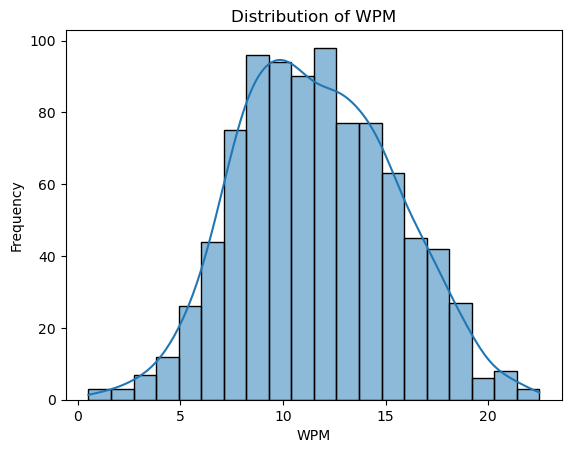

In [30]:
# why R does not have jiwer :(

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='wpm', kde=True)
plt.title('Distribution of WPM')
plt.xlabel('WPM')
plt.ylabel('Frequency')
plt.show()

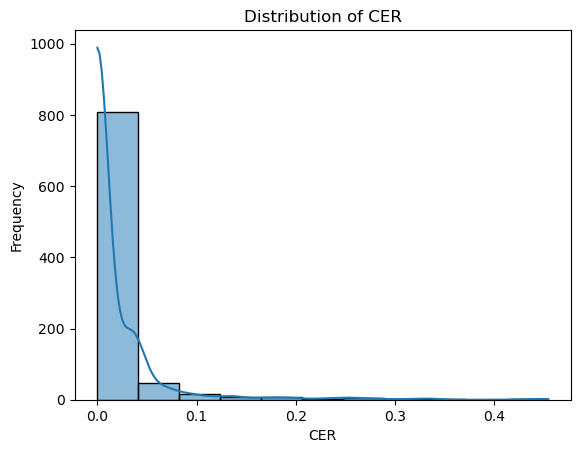

In [32]:
sns.histplot(data=df, x='cer', kde=True)
plt.title('Distribution of CER')
plt.xlabel('CER')
plt.ylabel('Frequency')
plt.show()

In [40]:
# wpm

from scipy.stats import ttest_ind

cognitive_wpm = df.loc[df['keyboard'] == 'cognitive', 'wpm']
baseline_wpm = df.loc[df['keyboard'] == 'baseline', 'wpm']

t_stat, p_value = ttest_ind(cognitive_wpm, baseline_wpm)

print("Two-Sample T-Test Results:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

Two-Sample T-Test Results:
t-statistic: -1.9072476810096701
p-value: 0.05680876621885939


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


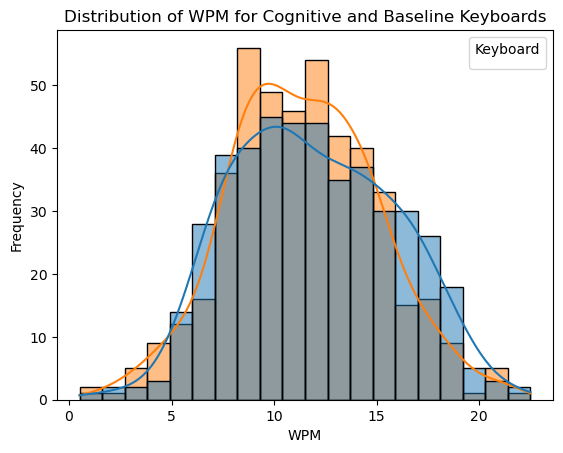

In [41]:
sns.histplot(data=df, x='wpm', hue='keyboard', kde=True)
plt.title('Distribution of WPM for Cognitive and Baseline Keyboards')
plt.xlabel('WPM')
plt.ylabel('Frequency')
plt.legend(title='Keyboard')
plt.show()

In [42]:
# cer

from scipy.stats import mannwhitneyu

cognitive_cer = df.loc[df['keyboard'] == 'cognitive', 'cer']
baseline_cer = df.loc[df['keyboard'] == 'baseline', 'cer']

statistic, p_value = mannwhitneyu(cognitive_cer, baseline_cer)

# Display the results
print("Mann-Whitney U Test Results:")
print("U-statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U Test Results:
U-statistic: 92971.5
p-value: 0.009466831216491946


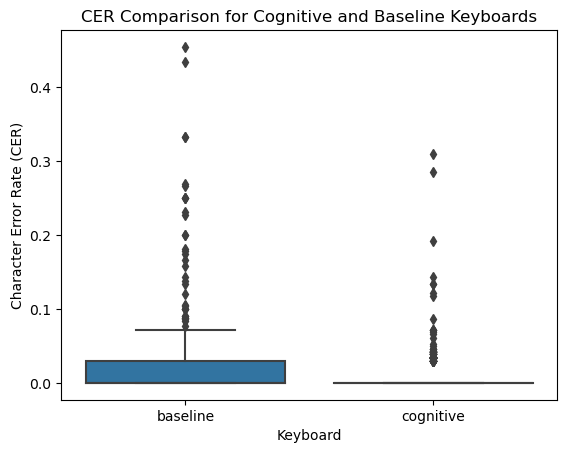

In [43]:
# Create a box plot of the CER values for cognitive and baseline keyboards using seaborn
sns.boxplot(data=df, x='keyboard', y='cer')
plt.title('CER Comparison for Cognitive and Baseline Keyboards')
plt.xlabel('Keyboard')
plt.ylabel('Character Error Rate (CER)')
plt.show()